# Multi-Phase Power Analysis: Simplified Script

## 1. Goal
This notebook calculates **Active Power**, **Loss**, and **Efficiency** for any electrical system with **N** phases. It also visualizes the key property of multi-phase power: **Constant Instantaneous Power**.

## 2. Key Concepts

### Active Power ($P$)
This is the useful power that performs work (like spinning a motor). It is calculated per phase based on the current magnitude ($I$), voltage ($V$), and the phase angle between them ($\phi$, the power factor angle):
$$P_{k} = V \cdot I_{k} \cdot \cos(\phi_{k})$$

### Loss and Efficiency ($\eta$)
Loss is the heat wasted in the wires ($I^2R$). Efficiency tells us how much of the energy generated actually reaches the load:
$$P_{loss} = \sum I_k^2 \cdot R$$
$$\eta = \frac{P_{Active}}{P_{Active} + P_{loss}} \times 100\%$$

### Instantaneous Power ($p(t)$)
The total instantaneous power ($p_{total}$) is the sum of the power being delivered by *all* phases at any single moment in time.
* **Balanced N-Phase System:** $p_{total}$ is a **flat, constant line**. This is the core benefit of multi-phase power, leading to smooth torque and less mechanical stress.
* **Single-Phase or Unbalanced System:** $p_{total}$ *wiggles* (pulsates), causing vibration and inefficiency.

### Libraries Import

In [53]:
import matplotlib.pyplot as plt
import numpy as np

### System Configuration

In [54]:
voltage_rms = 230      # Volts
line_resistance = 0.5  # Ohms
frequency = 50         # Hz

# Phase currents (amps)
current_mags = [7, 10, 9]

# Phase deviations (degrees)
phase_deviations = [0, 0, 0]

# Number of cycles
num_cycles = 3

# Printing Information
N = len(current_mags)
print(f"System Setup: {N}-Phase System initialized.")

System Setup: 3-Phase System initialized.


### Calculation Engine

In [ ]:
# Conversions
I_rms = np.array(current_mags)
phi_dev_rad = np.radians(np.array(phase_deviations))

# Creating ideal spacing angles
ref_angles = np.linspace(0, 2*np.pi, N, endpoint=False)
current_angles_rad = ref_angles + phi_dev_rad

# Calculating power and loss

# Active power delivered
power_per_phase = voltage_rms * I_rms * np.cos(phi_dev_rad)
total_active_power = np.sum(power_per_phase)

# Transmission loss
loss_per_phase = (I_rms ** 2) * line_resistance
total_loss = np.sum(loss_per_phase)

# Efficiency
power_input = total_active_power + total_loss
efficiency = (total_active_power / power_input) * 100 if power_input > 0 else 0

# Neutral current imbalance
current_phasors = I_rms * np.exp(1j * current_angles_rad)
neutral_current_mag = np.abs(np.sum(current_phasors))

# Time-domain data
t = np.linspace(0, 2/frequency, 1000) # 2 cycles
omega = num_cycles * np.pi * frequency

waveforms_i = np.zeros((N, len(t)))
waveforms_p = np.zeros((N, len(t)))

for k in range(N):
    # Current Waveform
    waveforms_i[k] = np.sqrt(2) * I_rms[k] * np.cos(omega * t - current_angles_rad[k])
    
    # Voltage Waveform (Reference)
    v_inst = np.sqrt(2) * voltage_rms * np.cos(omega * t - ref_angles[k])
    
    # Instantaneous Power (v(t) * i(t))
    waveforms_p[k] = v_inst * waveforms_i[k]

total_inst_power = np.sum(waveforms_p, axis=0)


# --- TEXT OUTPUT SUMMARY ---
print("-" * 45)
print(f"--- SYSTEM PERFORMANCE SUMMARY ({N}-PHASE) ---")
print("-" * 45)
print(f"Total Active Power (P_out) : {total_active_power/1000:.3f} kW")
print(f"Total Transmission Loss    : {total_loss:.2f} W")
print(f"System Efficiency          : {efficiency:.2f} %")
print(f"Imbalance (Neutral Current): {neutral_current_mag:.2f} A")
print("-" * 45)
if neutral_current_mag > 1.0:
    print("STATUS: System is UNBALANCED. Ripple and high neutral current detected.")
else:
    print("STATUS: System is BALANCED. Power is smooth.")

---------------------------------------------
--- SYSTEM PERFORMANCE SUMMARY (3-PHASE) ---
---------------------------------------------
Total Active Power (P_out) : 5.980 kW
Total Transmission Loss    : 115.00 W
System Efficiency          : 98.11 %
Imbalance (Neutral Current): 2.65 A
---------------------------------------------
STATUS: System is UNBALANCED. Ripple and high neutral current detected.


### Visualizing Results

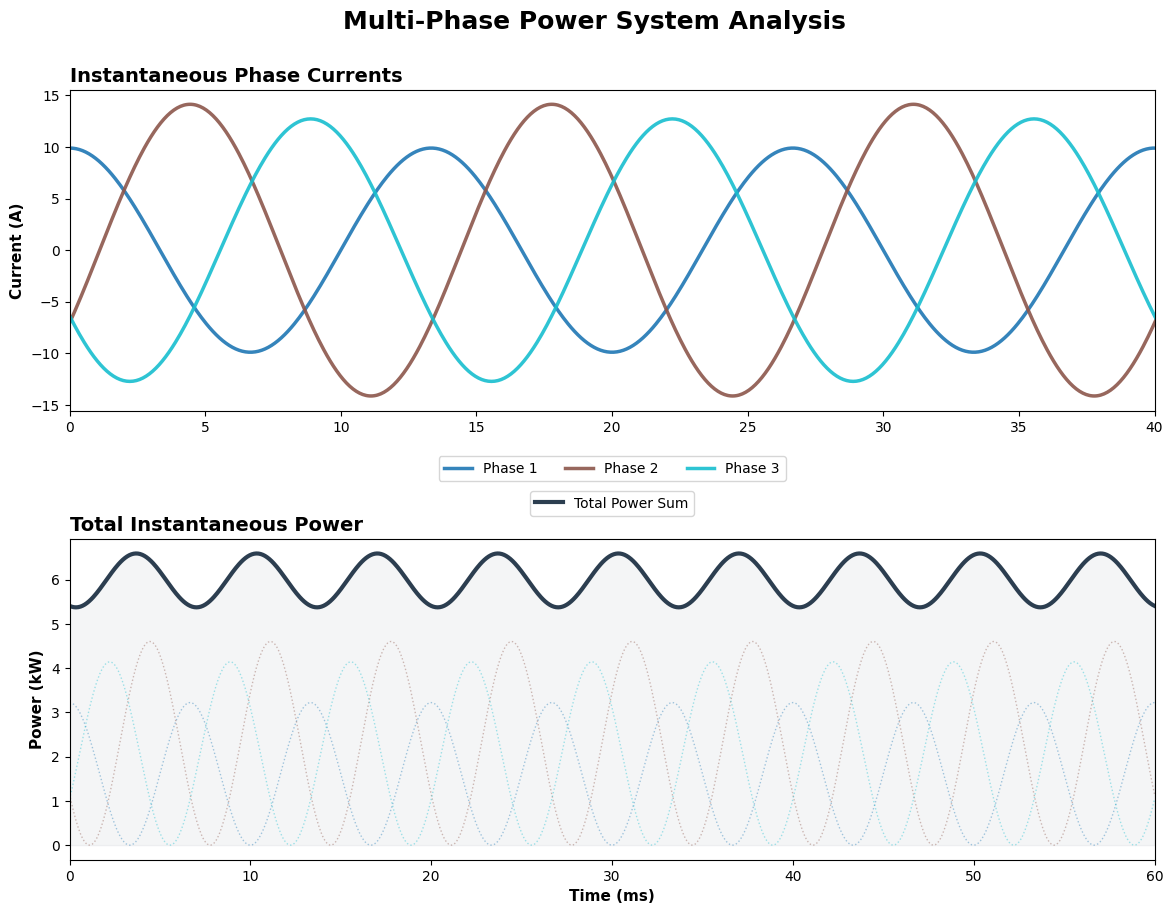

In [ ]:
# --- VISUALIZATION: CLEAN & WIDE ---

# 1. Setup the "Canvas"

# Create figure (Standard full width)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=100)
fig.suptitle("Multi-Phase Power System Analysis", fontsize=18, fontweight='bold', y=0.96)

# High contrast colors
colors = plt.cm.tab10(np.linspace(0, 1, N))

# ==========================================
# PLOT 1: CURRENT WAVEFORMS
# ==========================================
for k in range(N):
    ax1.plot(t * 1000, waveforms_i[k], 
             label=f'Phase {k+1}', 
             color=colors[k], 
             linewidth=2.5, 
             alpha=0.9)

ax1.set_title("Instantaneous Phase Currents", fontsize=14, loc='left', fontweight='bold')
ax1.set_ylabel("Current (A)", fontsize=11, fontweight='bold')
ax1.set_xlim(0, (2/frequency)*1000)
ax1.tick_params(labelsize=10)

# Legend at the bottom
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=False, ncol=N, fontsize=10, frameon=True)

# ==========================================
# PLOT 2: TOTAL POWER OUTPUT
# ==========================================

# 1. Draw individual phases (faint background)
for k in range(N):
    ax2.plot(t * 1000, waveforms_p[k] / 1000, 
             color=colors[k], linestyle=':', linewidth=1, alpha=0.4)

# 2. Draw Total Power (Bold)
# We add the numeric value to the label so it's still visible in the legend
avg_p_kw = total_active_power / 1000
ax2.plot(t * 1000, total_inst_power / 1000,
         color='#2c3e50', linewidth=3,
         label="Total Power Sum")

# 3. Fill area under the curve
ax2.fill_between(t * 1000, total_inst_power / 1000, 0, color='#2c3e50', alpha=0.05)

ax2.set_title("Total Instantaneous Power", fontsize=14, loc='left', fontweight='bold')
ax2.set_ylabel("Power (kW)", fontsize=11, fontweight='bold')
ax2.set_xlabel("Time (ms)", fontsize=11, fontweight='bold')
ax2.set_xlim(0, (2/frequency)*1000)

# Legend inside the plot (top right) to save space
ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=False, ncol=N, fontsize=10, frameon=True)

# ==========================================
# LAYOUT ADJUSTMENT
# ==========================================
plt.subplots_adjust(hspace=0.4)

plt.show()